In [1]:
%cd ..
from google.colab import drive
drive.mount('/content/gdrive')

# this creates a symbolic link so that now the path /content/gdrive/My\ Drive/ is equal to /mydrive
!ln -s /content/gdrive/My\ Drive/ /mydrive
!ls /mydrive
%cd /content/

/
Mounted at /content/gdrive
'Biwak miejsca.gmap'   data_for_train	       'Google Earth'   Passwords.kdbx
'Colab Notebooks'     'Forgotten places.gmap'  'My Drive'
/content


In [2]:
!git clone https://github.com/chandrikadeb7/Face-Mask-Detection.git

Cloning into 'Face-Mask-Detection'...
remote: Enumerating objects: 4563, done.
remote: Counting objects: 100% (39/39), done.
remote: Compressing objects: 100% (35/35), done.
remote: Total 4563 (delta 14), reused 8 (delta 2), pack-reused 4524
Receiving objects: 100% (4563/4563), 186.71 MiB | 33.23 MiB/s, done.
Resolving deltas: 100% (253/253), done.
Checking out files: 100% (4152/4152), done.


In [3]:
!rm -R sample_data
!mv Face-Mask-Detection/dataset/ /content
!rm -R Face-Mask-Detection/

In [4]:
import cv2
import os

import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
%matplotlib inline

In [5]:
def addMargine(img):
  max_dim = max(img.shape[0:2])
  empty_array = np.zeros((max_dim,max_dim,3),np.uint8)
  ax, ay = (max_dim - img.shape[1])//2,(max_dim - img.shape[0])//2
  empty_array[ay:img.shape[0]+ay,ax:ax+img.shape[1],:] = img
  return empty_array

def inputPrepare(img):
  img = addMargine(img)
  img = cv2.resize(img, (48, 48))
  return img/255

In [6]:
files = []
for filename in os.listdir("/content/dataset/with_mask"):
  files.append(filename)
img_mask = []
label_mask = []
for name in files:
  img = cv2.imread("/content/dataset/with_mask/"+name)
  img = inputPrepare(img)
  img_mask.append(img)
  label_mask.append(np.array([1,0]))

In [7]:
files = []
for filename in os.listdir("/content/dataset/without_mask"):
  files.append(filename)
img_nomask = []
label_nomask = []
for name in files:
  img = cv2.imread("/content/dataset/without_mask/"+name)
  img = inputPrepare(img)
  img_nomask.append(img)
  label_nomask.append(np.array([0,1]))

In [8]:
mask = img_mask + img_nomask
label = label_mask + label_nomask
mask_array = np.asarray(mask)
label_array = np.asarray(label)

In [9]:
X_train, X_valid, y_train, y_valid = train_test_split(mask_array, label_array,
                                                    shuffle=True, stratify=label_array,
                                                    test_size=0.1, random_state=42)
print(f"x_train: {X_train.shape}\ny_train: {y_train.shape}\nx_valid: {X_valid.shape}\ny_valid: {y_valid.shape}\n")

x_train: (3685, 48, 48, 3)
y_train: (3685, 2)
x_valid: (410, 48, 48, 3)
y_valid: (410, 2)



In [10]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(100, (3,3), activation='relu', input_shape=(48, 48, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(100, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.Dense(2, activation='softmax')
])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

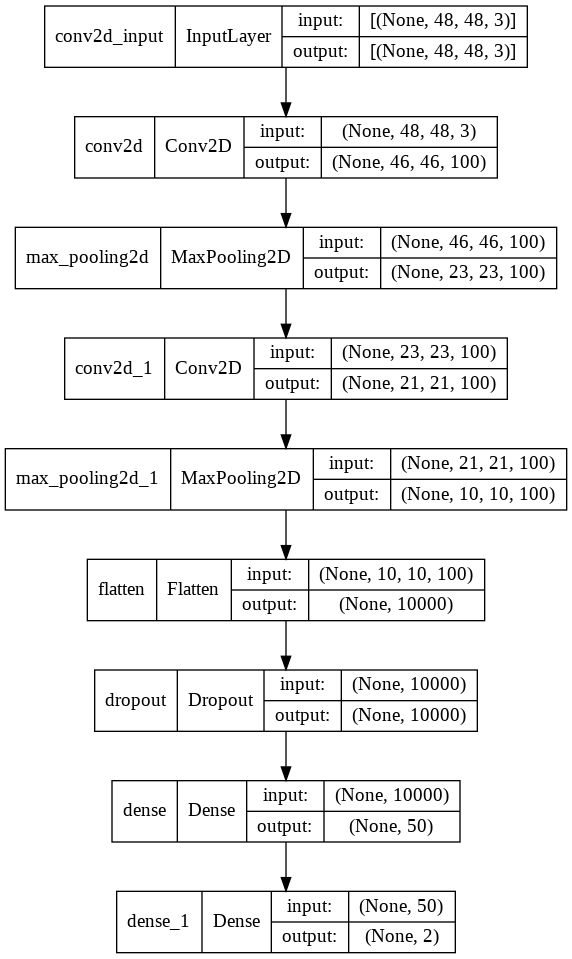

In [11]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [12]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_acc',
    min_delta=0.00005,
    patience=11,
    verbose=1,
    restore_best_weights=True,
)

lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_acc',
    factor=0.5,
    patience=7,
    min_lr=1e-7,
    verbose=1,
)

callbacks = [
    early_stopping,
    lr_scheduler,
]

In [13]:
batch_size = 32
epochs = 150
history = model.fit(x=X_train, y=y_train,
                    validation_data=(X_valid,y_valid),
                    steps_per_epoch=len(X_train) / batch_size,
                    batch_size=batch_size,
                    epochs=epochs, 
                    callbacks=callbacks)

Epoch 1/150
115/115 [==============================] - 32s 18ms/step - loss: 0.3324 - acc: 0.8575 - val_loss: 0.2299 - val_acc: 0.9122 - lr: 0.0010
Epoch 2/150
115/115 [==============================] - 2s 14ms/step - loss: 0.1959 - acc: 0.9248 - val_loss: 0.1607 - val_acc: 0.9390 - lr: 0.0010
Epoch 3/150
115/115 [==============================] - 2s 14ms/step - loss: 0.1487 - acc: 0.9387 - val_loss: 0.1576 - val_acc: 0.9390 - lr: 0.0010
Epoch 4/150
115/115 [==============================] - 2s 15ms/step - loss: 0.1239 - acc: 0.9536 - val_loss: 0.1086 - val_acc: 0.9610 - lr: 0.0010
Epoch 5/150
115/115 [==============================] - 2s 14ms/step - loss: 0.0939 - acc: 0.9631 - val_loss: 0.1368 - val_acc: 0.9463 - lr: 0.0010
Epoch 6/150
115/115 [==============================] - 2s 14ms/step - loss: 0.0759 - acc: 0.9712 - val_loss: 0.1399 - val_acc: 0.9317 - lr: 0.0010
Epoch 7/150
115/115 [==============================] - 2s 15ms/step - loss: 0.0692 - acc: 0.9731 - val_loss: 0.1106 -

In [ ]:
model.save('/mydrive/data_for_train/social_robot/mask_model_1.h5')

In [ ]:
!ls /mydrive/data_for_train/social_robot/

emotion_model_0.h5  fer2013.csv.zip  mask_model_0.h5  mask_model_1.h5


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-package

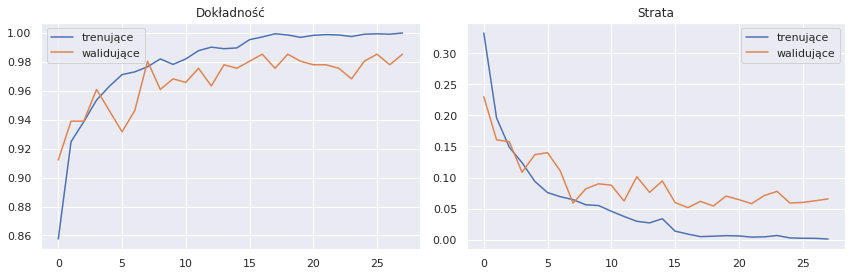

In [15]:
sns.set()
fig = plt.figure(0, (12, 4))

ax = plt.subplot(1, 2, 1)
sns.lineplot(history.epoch, history.history['acc'], label='trenujące')
sns.lineplot(history.epoch, history.history['val_acc'], label='walidujące')
plt.title('Dokładność')
plt.tight_layout()

ax = plt.subplot(1, 2, 2)
sns.lineplot(history.epoch, history.history['loss'], label='trenujące')
sns.lineplot(history.epoch, history.history['val_loss'], label='walidujące')
plt.title('Strata')
plt.tight_layout()

plt.savefig('epoch_history_dcnn.png')
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-package

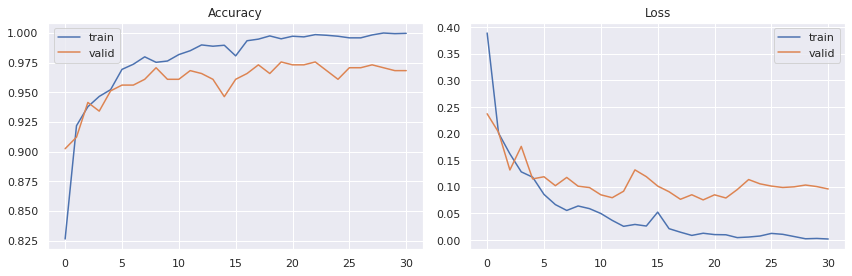

In [ ]:
sns.set()
fig = plt.figure(0, (12, 4))

ax = plt.subplot(1, 2, 1)
sns.lineplot(history.epoch, history.history['acc'], label='train')
sns.lineplot(history.epoch, history.history['val_acc'], label='valid')
plt.title('Accuracy')
plt.tight_layout()

ax = plt.subplot(1, 2, 2)
sns.lineplot(history.epoch, history.history['loss'], label='train')
sns.lineplot(history.epoch, history.history['val_loss'], label='valid')
plt.title('Loss')
plt.tight_layout()

plt.savefig('epoch_history_dcnn.png')
plt.show()

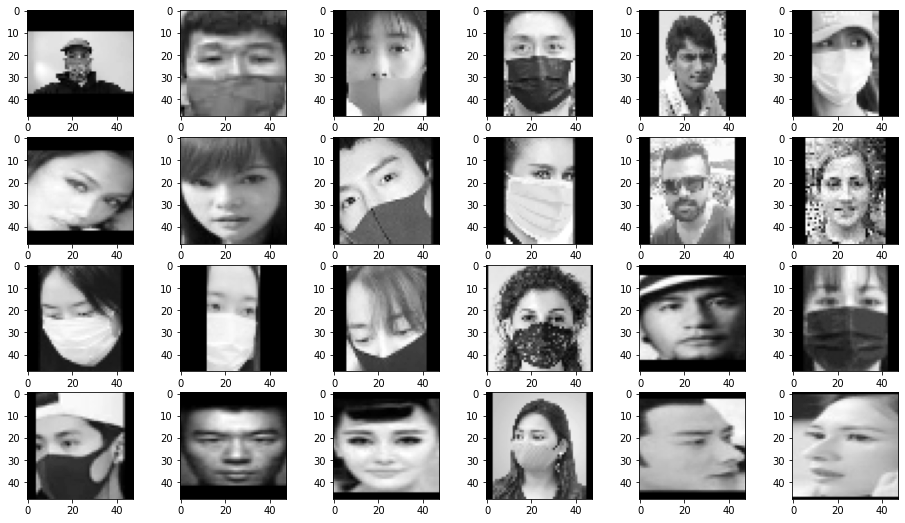

In [ ]:
fig, axs = plt.subplots(4, 6, figsize=(16,9))
index = 0
for i in range(4):
  for j in range(6):
    axs[i,j].imshow(X_train[index,:,:,0], cmap="gray")
    index = index + 1

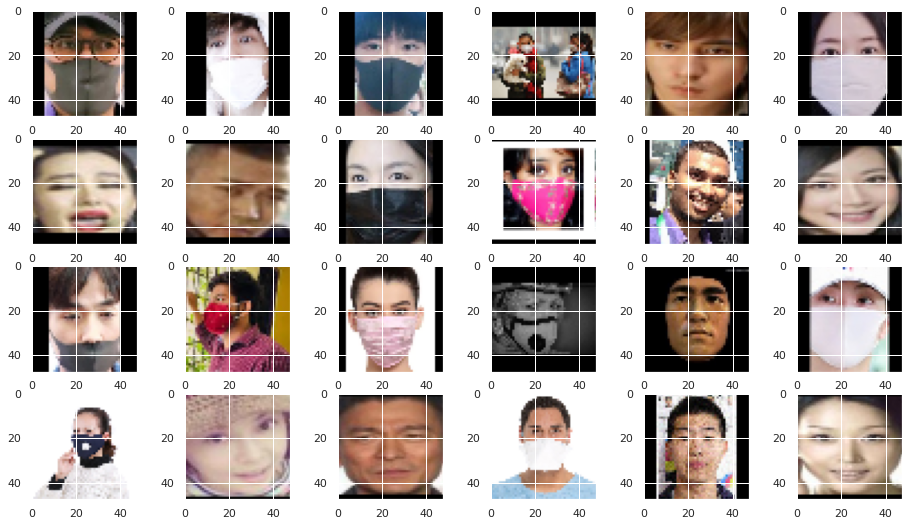

In [ ]:
fig, axs = plt.subplots(4, 6, figsize=(16,9))
index = 0
for i in range(4):
  for j in range(6):
    axs[i,j].imshow(X_train[index,:,:,::-1])
    index = index + 1

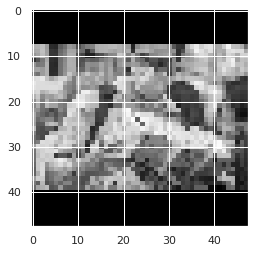

In [ ]:
plt.imshow(X_train[1].reshape(48,48)*255, cmap="gray")

In [ ]:
X_train[1,:,:,0]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])